In [269]:
import numpy as np
from numpy import ma
import xarray as xr
from glob import glob
from datetime import datetime, timedelta
from scipy import ndimage as ndi
from scipy import interpolate
from dateutil.parser import parse as parse_date
import argparse
from python_toolbox import abi_tools, dataset_tools, opt_flow
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

In [310]:
# Getting files (on jasmin)

base_path = '/gws/nopw/j04/eo_shared_data_vol2/scratch/satellite/GOES16/RadC/'

start_date = datetime(2018,6,19,17)
end_date = datetime(2018,6,19,19)
doy_start = (start_date - datetime(start_date.year, 1, 1)).days + 1
doy_end = (end_date - datetime(end_date.year, 1, 1)).days + 1

file_names = []
for year in range(start_date.year, end_date.year+1):
    year_str = str(year).zfill(4)
    if start_date.year == end_date.year:
        for doy in range(doy_start, doy_end+1):
            doy_str = str(doy).zfill(3)
            goes_path = base_path +year_str+'/'+doy_str+'/'
            file_names.extend(glob(goes_path+'*/*C08_*.nc'))
    elif year == start_date.year:
        for doy in range(doy_start, (datetime(year+1,1,1)-datetime(year,1,1)).days+1):
            doy_str = str(doy).zfill(3)
            goes_path = base_path +year_str+'/'+doy_str+'/'
            file_names.extend(glob(goes_path+'*/*C08_*.nc'))
    elif year == end_date.year:
        for doy in range(1, doy_end+1):
            doy_str = str(doy).zfill(3)
            goes_path = base_path +year_str+'/'+doy_str+'/'
            file_names.extend(glob(goes_path+'*/*C08_*.nc'))
    else:
        for doy in range(1, (datetime(year+1,1,1)-datetime(year,1,1)).days+1):
            doy_str = str(doy).zfill(3)
            goes_path = base_path +year_str+'/'+doy_str+'/'
            file_names.extend(glob(goes_path+'*/*C08_*.nc'))

# Get all filenames
goes_files = [abi_tools.get_goes_abi_files(f) for f in file_names]
# Filter for start and end date
goes_files = [f for f in goes_files if f[0] >= start_date and f[0] <= end_date and len(f) == 17]

len(goes_files)

23

In [311]:
# Get brightness temperature for channel 8,10,13 and 15
# Upper level water vapour (6.2um)
C8_data = abi_tools.get_abi_ds_from_files([f[8] for f in goes_files])[:,600:900,1300:1600]
# Lower level water vapour (7.3um)
C10_data = abi_tools.get_abi_ds_from_files([f[10] for f in goes_files])[:,600:900,1300:1600]
# Clean IR LW window channel(10.8um)
C13_data = abi_tools.get_abi_ds_from_files([f[13] for f in goes_files])[:,600:900,1300:1600]
# Dirty IR LW window channel(12.0um)
C15_data = abi_tools.get_abi_ds_from_files([f[15] for f in goes_files])[:,600:900,1300:1600]

dataset_tools.match_coords([C13_data,C10_data,C8_data,C15_data])


In [312]:
# water vapour and split window differences
wvd = (C8_data - C10_data).compute()
swd = (C13_data - C15_data).compute()


Text(0.5,1,'Split window difference')

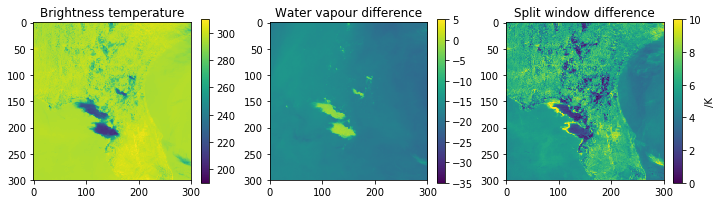

In [314]:
fig, ax = plt.subplots(1,3,figsize=(12,3))
bt = ax[0].imshow(C13_data[12], vmin=190,vmax=310)
plt.colorbar(bt, ax=ax[0])
ax[0].set_title('Brightness temperature')

wv = ax[1].imshow(wvd[12], vmin=-35,vmax=5)
plt.colorbar(wv, ax=ax[1])
ax[1].set_title('Water vapour difference')

sw = ax[2].imshow(swd[12], vmin=0,vmax=10)
plt.colorbar(sw, label='/K', ax=ax[2])
ax[2].set_title('Split window difference')


Note that the split window temperatures are low in the middle of deep clouds, but high at the edges. I am using this to distinguish between the core and anvil parts of DCCs

In [386]:
reload(opt_flow)

<module 'python_toolbox.opt_flow' from '/home/users/wkjones/miniconda2/envs/py3/lib/python3.7/site-packages/python_toolbox/opt_flow.py'>

In [379]:
field_flow = opt_flow.get_flow_func(C13_data, replace_missing=True)

Flow func can now be indexed and the individual vectors accessed separately:

In [383]:
field_flow[0,:10](1)[0].shape

(10, 300)

In [385]:
field_flow.flow_x_for[0]

masked_array(
  data=[[1.4818993804510683e-05, 0.00012256941408850253,
         0.000648028333671391, ..., -0.00031547140679322183,
         -0.00016869499813765287, -7.625847501913086e-05],
        [0.00010197902884101495, 0.0004917560727335513,
         0.001981194596737623, ..., -0.0015669530257582664,
         -0.0008494420908391476, -0.0003995429433416575],
        [0.0002878468076232821, 0.0012021645670756698,
         0.004277832340449095, ..., -0.005495015997439623,
         -0.002953304909169674, -0.0013966134283691645],
        ...,
        [3.1835167391136565e-08, 6.811669805983911e-08,
         7.503356869165145e-08, ..., -0.00788244977593422,
         -0.004165085032582283, -0.0017683912301436067],
        [1.671477178888381e-08, 4.577766787861037e-08,
         1.0113932091826427e-07, ..., -0.002694212831556797,
         -0.0014180302387103438, -0.0006058213184587657],
        [6.607642877298758e-09, 1.8811197932677715e-08,
         4.5178182972449576e-08, ..., -0.00070774

In [316]:
C13_data = C13_data.compute()

Text(0.5,1,'Y flow vector')

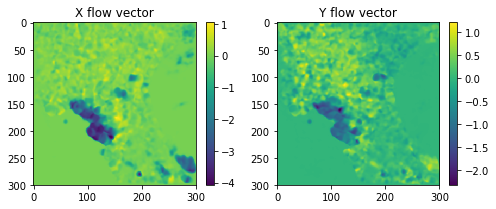

In [317]:
fig, ax = plt.subplots(1,2,figsize=(8,3))
x_vec = ax[0].imshow(field_flow(1)[0][12])
plt.colorbar(x_vec, ax=ax[0])
ax[0].set_title('X flow vector')

y_vec = ax[1].imshow(field_flow(1)[1][12])
plt.colorbar(y_vec, ax=ax[1])
ax[1].set_title('Y flow vector')



## Semi-lagrangian BT cooling

In [318]:
# this gets a 3*arr.shape array of the field interpolated by one frame forwards and backwards
bt_stack = opt_flow.get_flow_stack(C13_data, field_flow).data


In [319]:
dx, dy = abi_tools.get_abi_pixel_lengths(C13_data)

In [320]:
# delta t, and also the spatial second derivative to find peaks in the brightness temperature
bt_dt = np.gradient(bt_stack, axis=0)[1]
bt_grad = (np.minimum(np.maximum(ndi.gaussian_filter(
                np.gradient(np.gradient(bt_stack[1], axis=1), axis=1)/dy**2,
                (0,1.5,1.5)), 0), 1) 
           * np.minimum(np.maximum(ndi.gaussian_filter(
                np.gradient(np.gradient(bt_stack[1], axis=2), axis=2)/dx**2,
                (0,1.5,1.5)), 0), 1))**0.5

# gaussian filter applied to grad bt to reduce noise

Text(0.5,1,'grad BT')

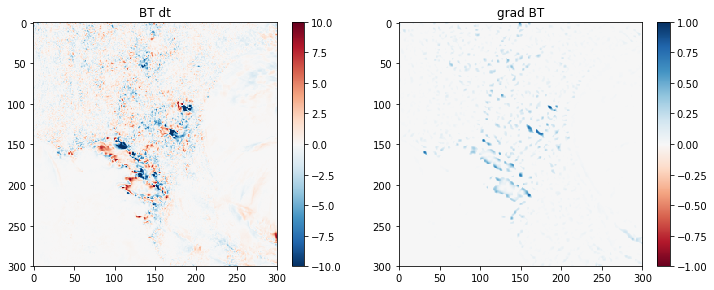

In [321]:
fig, ax = plt.subplots(1,2,figsize=(12,4.5))
btdt = ax[0].imshow(bt_dt[12],vmin=-10,vmax=10,cmap='RdBu_r')
plt.colorbar(btdt, ax=ax[0])
ax[0].set_title('BT dt')

gradbt = ax[1].imshow(bt_grad[12],vmin=-1,vmax=1,cmap='RdBu')
plt.colorbar(gradbt, ax=ax[1])
ax[1].set_title('grad BT')


By multiplying these fields we can get a metric for how much a peak in the BT field (positive grad) is growing (negative BTdt)

In [322]:
bt_growth = np.minimum(np.maximum(np.maximum(-bt_dt,0) * bt_grad, 0),10)


In [325]:
#dilate the field in a semi-lagrangian way
bt_growth = opt_flow.flow_convolve_nearest(bt_growth, field_flow, 
                                           structure=ndi.generate_binary_structure(3,2),
                                           function=np.nanmax)


/home/users/wkjones/miniconda2/envs/py3/lib/python3.7/site-packages/python_toolbox/opt_flow.py:269: RuntimeWarning: All-NaN axis encountered
  mask=mask, dtype=dtype), 0, **kwargs)


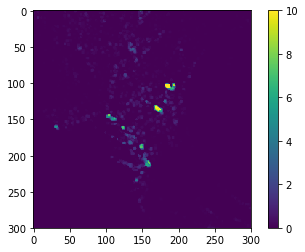

In [326]:
plt.imshow(bt_growth[12])
plt.colorbar()

Text(0.5,1,'BT growth metric')

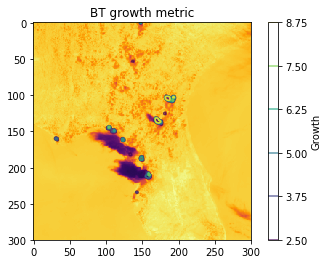

In [328]:
plt.imshow(C13_data[12],cmap='inferno',vmax=310,vmin=190)
plt.contour(bt_growth[12],np.arange(2.5,11.25,1.25), alpha=0.75)
# plt.gca().invert_yaxis()
plt.colorbar(label='Growth')
plt.title('BT growth metric')

I've found that 2.5 is a good value for this, it's approximately equal to a peak cooling of 0.5K/minute

New method multiplying x and y curvature fields rather than adding

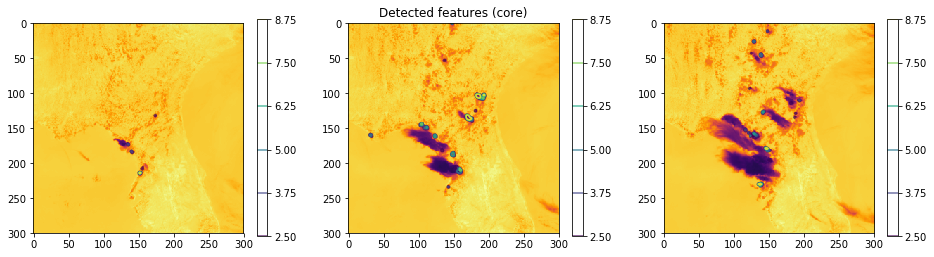

In [329]:
fig, ax = plt.subplots(1,3,figsize=(16,4))

m0 = ax[0].imshow(C13_data[0],cmap='inferno',vmin=190,vmax=310)
c0 = ax[0].contour(bt_growth[0],np.arange(2.5,11.25,1.25), alpha=0.75)
plt.colorbar(c0, ax=ax[0])

m1 = ax[1].imshow(C13_data[12],cmap='inferno',vmin=190,vmax=310)
c1 = ax[1].contour(bt_growth[12],np.arange(2.5,11.25,1.25), alpha=0.75)
plt.colorbar(c1, ax=ax[1])
ax[1].set_title('Detected features (core)')

m2 = ax[2].imshow(C13_data[-1],cmap='inferno',vmin=190,vmax=310)
c2 = ax[2].contour(bt_growth[-1],np.arange(2.5,11.25,1.25), alpha=0.75)
plt.colorbar(c2, ax=ax[2])


## Semi-lagrangian watershedding

In [327]:
upper_thresh = -5
lower_thresh = -15
markers = wvd>upper_thresh
markers = np.logical_and(markers, bt_growth>2.5).to_masked_array()
mask = (wvd<lower_thresh).to_masked_array()
for i in range(np.minimum(3, (mask.shape[0]-1)//2)):
    # Semi-lagrangian erosion of the mask by up to three steps
    mask = opt_flow.flow_convolve_nearest(mask, field_flow, 
                                          structure=ndi.generate_binary_structure(3,2),
                                          function=np.nanmin)

/home/users/wkjones/miniconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


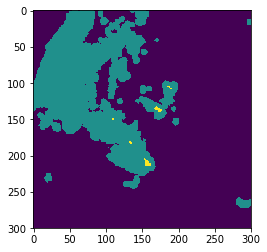

In [330]:
plt.imshow((markers.astype(int)-mask.astype(int))[12])

Markers in yellow. Mask in dark blue. Unfilled regions are in teal

In [331]:
# Sobel edge detection for watershedding. Combine WVD, SWD and growth to find regions
inner_edges = opt_flow.flow_sobel(opt_flow.get_flow_stack(
                                      xr.DataArray(
                                          np.minimum(np.maximum(
                                              opt_flow.flow_convolve( 
                                                  opt_flow.get_flow_stack((wvd-swd+bt_growth-5).compute(), 
                                                                          field_flow, method='linear').to_masked_array(), 
                                                  function=np.nanmax)
                                              , lower_thresh), upper_thresh), 
                                          dims=('t','y','x')),
                                      field_flow).compute().to_masked_array(), 
                                  direction='uphill', magnitude=True)


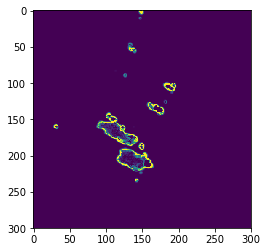

In [332]:
plt.imshow(inner_edges[12],vmin=0,vmax=50)

In [580]:
from importlib import reload; reload(opt_flow)

<module 'python_toolbox.opt_flow' from '/home/users/wkjones/miniconda2/envs/py3/lib/python3.7/site-packages/python_toolbox/opt_flow.py'>

In [560]:
field_flow.shape = field_flow.flow_x_for.shape

In [ ]:
# Watershed
features = opt_flow.flow_network_watershed(inner_edges, markers, field_flow, mask=mask, 
                                           structure=ndi.morphology.generate_binary_structure(3,2), 
                                           debug_mode=True)


Calculating nearest neighbours
Finding network convergence locations
Pixels to fill: 486319
Convergence
Iteration: 1
Pixels converged 1673546
Convergence
Iteration: 2
Pixels converged 1733193
Convergence
Iteration: 3
Pixels converged 1813464
Convergence
Iteration: 4
Pixels converged 1917444
Convergence
Iteration: 5
Pixels converged 2016507
Convergence
Iteration: 6
Pixels converged 2065821
Convergence
Iteration: 7
Pixels converged 2070000
All pixels converged
Filling basins
Joining labels
Max label: 2480
max_markers: 1
Iteration: 1
Remaining labels: 374


In [ ]:
fig, ax = plt.subplots(1,3,figsize=(12,3))

m0 = ax[0].imshow(C13_data[0],vmin=190,vmax=310)
plt.colorbar(m0, ax=ax[0])
ax[0].contour(features[0],[0.5],colors=['red'])

m1 = ax[1].imshow(C13_data[12],vmin=190,vmax=310)
plt.colorbar(m1, ax=ax[1])
ax[1].contour(features[12],[0.5],colors=['red'])
ax[1].set_title('Detected features (core) new method')

m2 = ax[2].imshow(C13_data[-1],vmin=190,vmax=310)
plt.colorbar(m2, ax=ax[2])
ax[2].contour(features[-1],[0.5],colors=['red'])


In [550]:
reload(opt_flow)

<module 'python_toolbox.opt_flow' from '/home/users/wkjones/miniconda2/envs/py3/lib/python3.7/site-packages/python_toolbox/opt_flow.py'>

In [551]:
test = pdb.runcall(opt_flow.flow_network_watershed, inner_edges, markers, field_flow, mask=mask, 
                                           structure=ndi.morphology.generate_binary_structure(3,1), 
                                           debug_mode=True)


> /home/users/wkjones/miniconda2/envs/py3/lib/python3.7/site-packages/python_toolbox/opt_flow.py(558)flow_network_watershed()
-> if structure is None:
(Pdb) until 814
Calculating nearest neighbours
Finding network convergence locations
Pixels to fill: 480025
Convergence
Iteration: 1
Pixels converged 1671627
Convergence
Iteration: 2
Pixels converged 1722779
Convergence
Iteration: 3
Pixels converged 1789449
Convergence
Iteration: 4
Pixels converged 1882867
Convergence
Iteration: 5
Pixels converged 1987270
Convergence
Iteration: 6
Pixels converged 2049485
Convergence
Iteration: 7
Pixels converged 2069997
Convergence
Iteration: 8
Pixels converged 2070000
All pixels converged
Filling basins
Joining labels
Max label: 8401
max_markers: 1
--Return--
> /home/users/wkjones/miniconda2/envs/py3/lib/python3.7/site-packages/python_toolbox/opt_flow.py(811)flow_network_watershed()->None
-> + [get_new_label(k) for k in range(max_markers+1, n_bins)],
(Pdb) n


AssertionError: 

In [552]:
pdb.pm()

> /home/users/wkjones/miniconda2/envs/py3/lib/python3.7/site-packages/python_toolbox/opt_flow.py(806)get_new_label()
-> assert output != j
(Pdb) l
801  	                raise ValueError("Output label is masked!")
802  	            else:
803  	                output = output.item()
804  	            # and check if nan
805  	            if np.all(np.isfinite(output)):
806  ->	                assert output != j
807  	                return output
808  	            else:
809  	                raise ValueError("Output label is not finite!")
810  	        new_label = ma.array(list(range(max_markers+1))
811  	                             + [get_new_label(k) for k in range(max_markers+1, n_bins)],
(Pdb) output
2
(Pdb) j
*** The 'jump' command requires a line number
(Pdb) !j
2
(Pdb) np.all(min_edge.mask.ravel()[wh])
False
(Pdb) np.sum(min_edge.mask.ravel()[wh])
1786
(Pdb) wh.size
2492
(Pdb) np.maximum(min_edge.ravel()[wh], field.ravel()[wh])
masked_array(data=[0.0, --, --, ..., --, --, 3.076740

(Pdb) np.unique(fill.ravel()[inds_edge.ravel()[wh][np.logical_not(min_edge.mask.ravel()[wh])]])
array([   0,    2,    3,    6,    7,   12,  237,  415,  653,  654,  658,
       1210, 1497, 1780, 1786, 2073, 2388, 2694, 2709, 4413, 4840, 5261,
       6219, 6711, 6730, 7277, 7836], dtype=int16)
(Pdb) np.unique(fill.ravel()[inds_edge.ravel()[wh][min_edge.mask.ravel()[wh]]])
array([   0,    2, 1497, 2073, 3666, 6708, 6711, 7247, 7248], dtype=int16)
(Pdb) u
> /home/users/wkjones/miniconda2/envs/py3/lib/python3.7/site-packages/python_toolbox/opt_flow.py(811)<listcomp>()
-> + [get_new_label(k) for k in range(max_markers+1, n_bins)],
(Pdb) l
806  	                assert output != j
807  	                return output
808  	            else:
809  	                raise ValueError("Output label is not finite!")
810  	        new_label = ma.array(list(range(max_markers+1))
811  ->	                             + [get_new_label(k) for k in range(max_markers+1, n_bins)],
812  	                       

In [347]:
inds = np.arange(inner_edges.size).reshape(inner_edges.shape)

In [511]:
reload(opt_flow)

<module 'python_toolbox.opt_flow' from '/home/users/wkjones/miniconda2/envs/py3/lib/python3.7/site-packages/python_toolbox/opt_flow.py'>

In [512]:
min_convolve = opt_flow.flow_convolve_nearest( inds[:,50:250,:], field_flow[:,50:250,:],
                                         structure=ndi.generate_binary_structure(3,1), function=np.min,
                                         dtype=np.int32, debug=True)

In [514]:
argmin_convolve = opt_flow.flow_convolve_nearest( inds[:,50:250,:], field_flow[:,50:250,:],
                                         structure=ndi.generate_binary_structure(3,1), function=np.argmin,
                                         dtype=np.uint8, debug=True)

In [478]:
min_convolve.dtype

dtype('int32')

In [515]:
test_min_convolve = opt_flow.flow_argmin_nearest( inds[:,50:250,:], argmin_convolve, field_flow[:,50:250,:],
                                         structure=ndi.generate_binary_structure(3,1),
                                         dtype=np.int32)

In [498]:
test_min_convolve = pdb.runcall(opt_flow.flow_argmin_nearest, inds[:,50:250,:], argmin_convolve, field_flow[:,50:250,:],
                                         structure=ndi.generate_binary_structure(3,1),
                                         dtype=np.int32)

> /home/users/wkjones/miniconda2/envs/py3/lib/python3.7/site-packages/python_toolbox/opt_flow.py(338)flow_argmin_nearest()
-> if dtype == None:
(Pdb) until 348
> /home/users/wkjones/miniconda2/envs/py3/lib/python3.7/site-packages/python_toolbox/opt_flow.py(349)flow_argmin_nearest()
-> for t in range(argmin.shape[0]):
(Pdb) l
344  	
345  	    shape_arrays = np.meshgrid(*(np.arange(s, dtype=int) for s in argmin.shape[1:]), indexing='ij')
346  	
347  	    out_arr = ma.empty(argmin.shape, dtype=dtype)
348  	
349  ->	    for t in range(argmin.shape[0]):
350  	        argmin_offsets = [wh[argmin[t]]-1 for wh in np.where(structure!=0)]
351  	
352  	        whp1 = (argmin_offsets[0] == 1)
353  	        whm1 = (argmin_offsets[0] == -1)
354  	
(Pdb) data.shape
(23, 200, 300)
(Pdb) argmin.shape
(23, 200, 300)
(Pdb) flow_func(1).shape
*** AttributeError: 'tuple' object has no attribute 'shape'
(Pdb) flow_func(1)[0].shape
(23, 200, 300)
(Pdb) until 368
> /home/users/wkjones/miniconda2/envs/py3/lib/

*interactive*


In : np.all(data.ravel()[ravelled_index].reshape(out_arr.shape[1:])) == data[tuple([argmin_offsets[i]%data.shape[i] for i in range(3)])])


SyntaxError: invalid syntax (<console>, line 1)

In : data[tuple([argmin_offsets[i]%data.shape[i] for i in range(3)])]


array([[105000, 105001, 105002, ..., 105297, 105298, 105299],
       [105300, 105301, 105302, ...,  15897,  15898,  15899],
       [ 15900,  15901,  15902, ...,  15896,  15897,  15898],
       ...,
       [164100, 164101, 164102, ..., 164397, 164398, 164399],
       [164400, 164401, 164402, ..., 164697, 164698, 164699],
       [164700, 164701, 164702, ..., 164997, 164998, 164999]])

In : np.all(data.ravel()[ravelled_index].reshape(out_arr.shape[1:]) == data[tuple([argmin_offsets[i]%data.shape[i] for i in range(3)])])


True

In : data.ravel()[ravelled_index].reshape(out_arr.shape[1:]))


SyntaxError: invalid syntax (<console>, line 1)

In : data.ravel()[ravelled_index].reshape(out_arr.shape[1:])


array([[105000, 105001, 105002, ..., 105297, 105298, 105299],
       [105300, 105301, 105302, ...,  15897,  15898,  15899],
       [ 15900,  15901,  15902, ...,  15896,  15897,  15898],
       ...,
       [164100, 164101, 164102, ..., 164397, 164398, 164399],
       [164400, 164401, 164402, ..., 164697, 164698, 164699],
       [164700, 164701, 164702, ..., 164997, 164998, 164999]])

In : t


0

In : import sys; sys.exut()


AttributeError: module 'sys' has no attribute 'exut'

In : sys.exit()


SystemExit: 

In [500]:
min_convolve[0].data

array([[15000, 15000, 15001, ..., 15296, 15297, 15298],
       [15000, 15001, 15002, ..., 15297, 15298, 15299],
       [15300, 15301, 15302, ..., 15597, 15598, 15599],
       ...,
       [73800, 73801, 73802, ..., 74097, 74098, 74099],
       [74100, 74101, 74102, ..., 74397, 74398, 74399],
       [74400, 74401, 74402, ..., 74697, 74698, 74699]], dtype=int32)

In [504]:
argmin_convolve[0].data

array([[3, 2, 2, ..., 2, 2, 2],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)

In [507]:
np.argmin(ma.array(np.arange(5,dtype=np.uint8), mask=[1,0,0,0,0]))

1

In [506]:
ma.array(np.arange(5,dtype=int), mask=[1,0,0,0,0])

masked_array(data=[--, 1, 2, 3, 4],
             mask=[ True, False, False, False, False],
       fill_value=999999)

In [516]:
np.sum(min_convolve != test_min_convolve)

0

In [484]:
test_min_convolve.shape

(23, 200, 300)

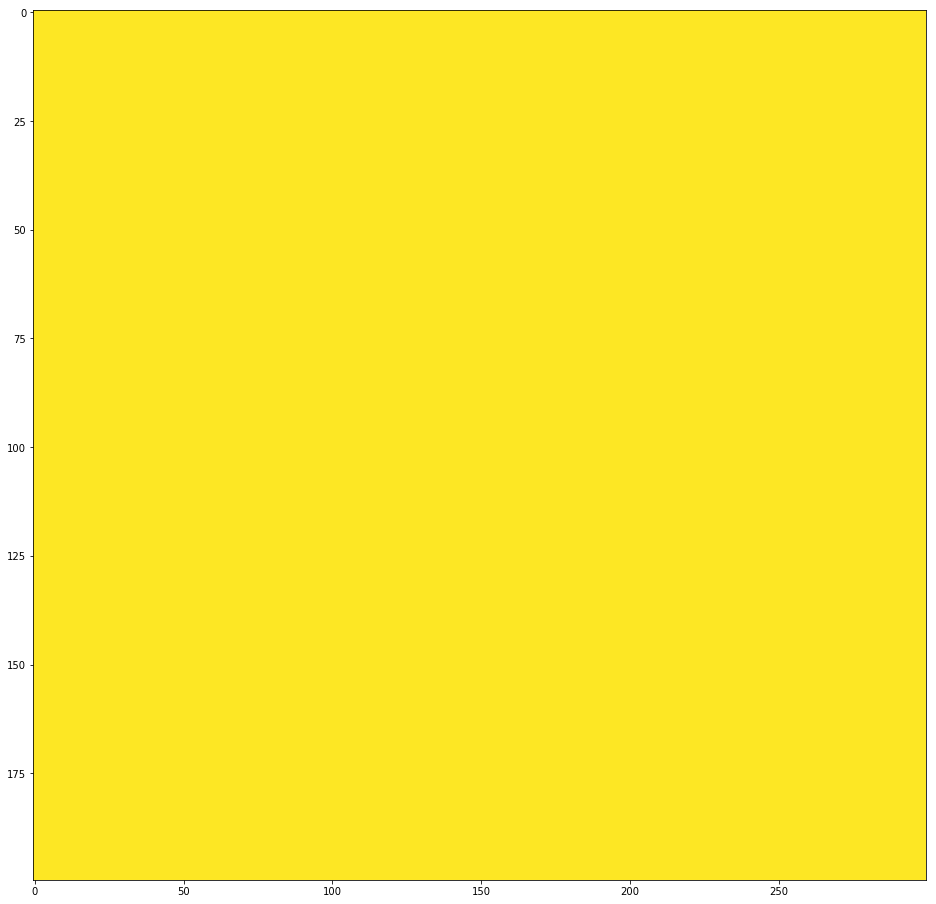

In [510]:
plt.figure(figsize=(16,16))
plt.imshow((min_convolve[1] == test_min_convolve[1]), vmin=0,vmax=1, aspect='auto')

In [433]:
import pdb; pdb.pm()

> /home/users/wkjones/miniconda2/envs/py3/lib/python3.7/site-packages/python_toolbox/opt_flow.py(357)<listcomp>()
-> + shape_arrays[0])
(Pdb) u
> /home/users/wkjones/miniconda2/envs/py3/lib/python3.7/site-packages/python_toolbox/opt_flow.py(357)flow_argmin_nearest()
-> + shape_arrays[0])
(Pdb) argmin_offsets
*** NameError: name 'argmin_offsets' is not defined
(Pdb) l
352  	        whp1 = (argmin_offsets[0] == 1)
353  	        whm1 = (argmin_offsets[0] == -1)
354  	
355  	        argmin_offsets[1] += (np.round(flow_func.flow_y_for[t]).astype(int)*whp1
356  	                              + np.round(flow_func.flow_y_back[t]).astype(int)*whm1
357  ->	                              + shape_arrays[0])
358  	        argmin_offsets[2] += (np.round(flow_func.flow_x_for[t]).astype(int)*whp1
359  	                              + np.round(flow_func.flow_x_back[t]).astype(int)*whm1
360  	                              + shape_arrays[1])
361  	
362  	        ravelled_index = np.ravel_multi_index([(arg

In [423]:
min_convolve.shape

(23, 300, 300)

In [401]:
hasattr(np.argmin, 'dtype')

False

In [402]:
import inspect

AttributeError: 'function' object has no attribute 'func_code'

In [387]:
min_convolve = pdb.runcall(opt_flow.flow_convolve_nearest, inds, field_flow,
                                         structure=ndi.generate_binary_structure(3,2), function=ma.argmin,
                                         dtype=np.uint8, debug=True)

> /home/users/wkjones/miniconda2/envs/py3/lib/python3.7/site-packages/python_toolbox/opt_flow.py(240)flow_convolve_nearest()
-> if dtype == None:
(Pdb) ll
207  	def flow_convolve_nearest(data, flow_func, structure=None, wrap=False, function=None, dtype=None, debug=False, **kwargs):
208  	    """
209  	    A function to compute a Semi-Lagrangian convolution using the nearest neighbour method. This can be performed
210  	    faster as no interpolation is required.
211  	    Input:
212  	        data:
213  	            An n-dimensional array or array-like input of values to perform the convolution on
214  	        flow_func:
215  	            A lambda function that returns the flow vectors of the data field in n-1 dimensions
216  	
217  	    Output:
218  	        convolve_data:
219  	            An output array of convoluted data. If not function keyword is provided, this will be an n+1
220  	            dimension array, where the leading dimension is the same length as the number of non-

(Pdb) flow_func.flow_y_for.shape
(23, 300, 300)
(Pdb) np.any(flow_func.flow_y_for.mask)
False
(Pdb) test = flow_inds[1] + (np.round(flow_func.flow_y_back.data)*wh).astype(int)
*** KeyboardInterrupt
(Pdb) test = flow_inds[1][0] + (np.round(flow_func.flow_y_back.data)*wh).astype(int)
*** KeyboardInterrupt
(Pdb) test = flow_inds[1][0] + (np.round(flow_func.flow_y_back.data)*wh[0]).astype(int)
(Pdb) flow_inds[1][:,0].shape
(19, 300, 1)
(Pdb) flow_inds[1][:,0:§].shape
*** SyntaxError: invalid character in identifier
(Pdb) flow_inds[1][:,0:1].shape
(19, 1, 300, 1)
(Pdb) test = flow_inds[1][:,0] + (np.round(flow_func.flow_y_back.data[0])*wh[:,0]).astype(int)
(Pdb) test.shape
(19, 300, 300)
(Pdb) q


In [367]:
flow_forward = field_flow(1)

In [368]:
tr = np.round(flow_forward[0])

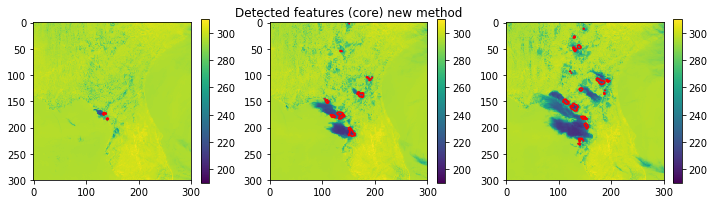

In [518]:
fig, ax = plt.subplots(1,3,figsize=(12,3))

m0 = ax[0].imshow(C13_data[0],vmin=190,vmax=310)
plt.colorbar(m0, ax=ax[0])
ax[0].contour(features[0],[0.5],colors=['red'])

m1 = ax[1].imshow(C13_data[12],vmin=190,vmax=310)
plt.colorbar(m1, ax=ax[1])
ax[1].contour(features[12],[0.5],colors=['red'])
ax[1].set_title('Detected features (core) new method')

m2 = ax[2].imshow(C13_data[-1],vmin=190,vmax=310)
plt.colorbar(m2, ax=ax[2])
ax[2].contour(features[-1],[0.5],colors=['red'])


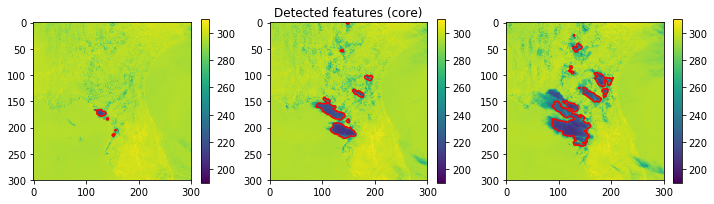

In [305]:
fig, ax = plt.subplots(1,3,figsize=(12,3))

m0 = ax[0].imshow(C13_data[60],vmin=190,vmax=310)
plt.colorbar(m0, ax=ax[0])
ax[0].contour(features[60],[0.5],colors=['red'])

m1 = ax[1].imshow(C13_data[72],vmin=190,vmax=310)
plt.colorbar(m1, ax=ax[1])
ax[1].contour(features[72],[0.5],colors=['red'])
ax[1].set_title('Detected features (core)')

m2 = ax[2].imshow(C13_data[84],vmin=190,vmax=310)
plt.colorbar(m2, ax=ax[2])
ax[2].contour(features[84],[0.5],colors=['red'])


Repeat for outer regions

In [577]:

outer_edges = opt_flow.flow_sobel(opt_flow.get_flow_stack(
                                      xr.DataArray(
                                          np.minimum(np.maximum(
                                              opt_flow.flow_convolve(
                                                  opt_flow.get_flow_stack((wvd+swd+bt_growth-5).compute(), 
                                                                          field_flow, method='linear').to_masked_array(), 
                                                  function=np.nanmax)
                                              , lower_thresh), upper_thresh), 
                                          dims=('t','y','x')),
                                      field_flow).compute().to_masked_array(), 
                                  direction='uphill', magnitude=True)


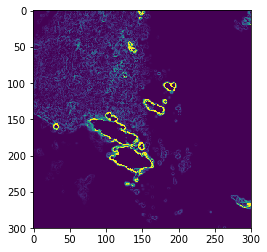

In [578]:
plt.imshow(outer_edges[12],vmin=0,vmax=50)

In [579]:
# Watershed
outer = opt_flow.flow_network_watershed(outer_edges, features, field_flow, mask=mask, 
                                           structure=ndi.morphology.generate_binary_structure(3,2), 
                                           debug_mode=True)


Calculating nearest neighbours
Finding network convergence locations
Pixels to fill: 433792
Convergence
Iteration: 1
Pixels converged 1961841
Convergence
Iteration: 2
Pixels converged 2043164
Convergence
Iteration: 3
Pixels converged 2059574
Convergence
Iteration: 4
Pixels converged 2067598
Convergence
Iteration: 5
Pixels converged 2070000
All pixels converged
Filling basins
Joining labels
Max label: 12816
max_markers: 1
Iteration: 1
Remaining labels: 5325
Iteration: 2
Remaining labels: 2949
Iteration: 3
Remaining labels: 1784
Iteration: 4
Remaining labels: 1099
Iteration: 5
Remaining labels: 690
Iteration: 6
Remaining labels: 442
Iteration: 7
Remaining labels: 273
Iteration: 8
Remaining labels: 186
Iteration: 9
Remaining labels: 126


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(12,3))

m0 = ax[0].imshow(C13_data[0],vmin=190,vmax=310)
plt.colorbar(m0, ax=ax[0])
ax[0].contour(outer[0],[0.5],colors=['blue'])
ax[0].contour(features[0],[0.5],colors=['red'])

m1 = ax[1].imshow(C13_data[12],vmin=190,vmax=310)
plt.colorbar(m1, ax=ax[1])
ax[1].contour(outer[12],[0.5],colors=['blue'])
ax[1].contour(features[12],[0.5],colors=['red'])
ax[1].set_title('Detected features (outer+core)')

m2 = ax[2].imshow(C13_data[-1],vmin=190,vmax=310)
plt.colorbar(m2, ax=ax[2])
ax[2].contour(outer[-1],[0.5],colors=['blue'])
ax[2].contour(features[-1],[0.5],colors=['red'])


The 'outer' region seems to pick up the extent of the anvil outflow fairly well

Picking out the mean brightness temperature of each region at each step and plotting one. Looks reasonable

In [ ]:
inner_labels = ndi.label(features)[0]
bt_labels = [[np.nanmean(C13_data[j].data.ravel()[(inner_labels[j]==i).ravel()]) 
              for j in range(C13_data.shape[0]) if np.any(inner_labels[j]==i)] 
             for i in np.arange(1,inner_labels.max()+1)]

In [ ]:
plt.plot(bt_labels[0])
plt.gca().invert_yaxis()

In [ ]:
for i in range(len(bt_labels)):
    plt.plot(bt_labels[i])
plt.gca().invert_yaxis()

In [ ]:
outer_labels = ndi.label(outer)[0]
bt_labels2 = [[np.nanmean(C13_data[j].data.ravel()[(outer_labels[j]==i).ravel()]) 
              for j in range(C13_data.shape[0]) if np.any(outer_labels[j]==i)] 
             for i in np.arange(1,outer_labels.max()+1)]

In [ ]:
plt.plot(bt_labels2[0])
plt.gca().invert_yaxis()

In [ ]:
for i in range(len(bt_labels2)):
    plt.plot(bt_labels2[i])
plt.gca().invert_yaxis()

In [ ]:
inner_labels = ndi.label(features)[0]
max_labels = [[np.nanmin(C13_data[j].data.ravel()[(inner_labels[j]==i).ravel()]) 
              for j in range(C13_data.shape[0]) if np.any(inner_labels[j]==i)] 
             for i in np.arange(1,inner_labels.max()+1)]

In [ ]:
plt.plot(max_labels[0])
plt.gca().invert_yaxis()

In [ ]:
inner_labels = ndi.label(features)[0]
growth_labels = [[np.nanmax(bt_growth[j].data.ravel()[(inner_labels[j]==i).ravel()]) 
              for j in range(C13_data.shape[0]) if np.any(inner_labels[j]==i)] 
             for i in np.arange(1,inner_labels.max()+1)]

In [ ]:
plt.plot(growth_labels[0])
# plt.gca().invert_yaxis()

In [ ]:
inner_labels = ndi.label(features)[0]
growth_labels = [[np.nanmean(bt_growth[j].data.ravel()[(inner_labels[j]==i).ravel()]) 
              for j in range(C13_data.shape[0]) if np.any(inner_labels[j]==i)] 
             for i in np.arange(1,inner_labels.max()+1)]

In [ ]:
plt.plot(growth_labels[0])
# plt.gca().invert_yaxis()

Comparison with GLM data

In [64]:
glm_path = '/gws/nopw/j04/eo_shared_data_vol2/scratch/satellite/GOES16/GLM/2018/170/*'
glm_files = glob(glm_path+'/OR_GLM-L2-LCFA_*.nc')
glm_files.sort()
glm_dates = [abi_tools.get_abi_date_from_filename(f) for f in glm_files]
glm_dates_array = np.array(glm_dates)

In [65]:
glm_files[0]

'/gws/nopw/j04/eo_shared_data_vol2/scratch/satellite/GOES16/GLM/2018/170/00/OR_GLM-L2-LCFA_G16_s20181700000000_e20181700000200_c20181700000226.nc'

In [71]:
p = abi_tools.get_abi_proj(C13_data[0])
height=C13_data[0].goes_imager_projection.perspective_point_height

In [98]:
# Get lightning event and flash locations
event_x = []
event_y = []
flash_x = []
flash_y = []
for abi_file in goes_files:
#     abi_file = goes_files[f_ind]
    wh_dates = np.all([glm_dates_array>=abi_file[0], glm_dates_array<(abi_file[0]+timedelta(minutes=5))], axis=0)
    matched_glm_files = np.array(glm_files)[wh_dates]
    t_event_x = []
    t_event_y = []
    t_flash_x = []
    t_flash_y = []
    for glm_file in matched_glm_files:
        with xr.open_dataset(glm_file) as glm_ds:
            temp_x, temp_y = (output/height for output in p(glm_ds.event_lon.data, glm_ds.event_lat.data))
            t_event_x.append(temp_x)
            t_event_y.append(temp_y)
            temp_x, temp_y = (output/height for output in p(glm_ds.flash_lon.data, glm_ds.flash_lat.data))
            t_flash_x.append(temp_x)
            t_flash_y.append(temp_y)

    event_x.append(np.concatenate(t_event_x))
    event_y.append(np.concatenate(t_event_y))
    flash_x.append(np.concatenate(t_flash_x))
    flash_y.append(np.concatenate(t_flash_y))

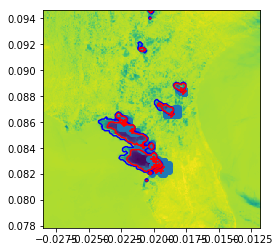

In [203]:
plt.imshow(C13_data[f_ind], extent=(C13_data[0].x[0].item(),
                                C13_data[0].x[-1].item(),
                                C13_data[0].y[-1].item(),
                                C13_data[0].y[0].item()))
plt.contour(C13_data[0].x, C13_data[0].y, outer[f_ind],[0.5],colors=['blue'])
plt.contour(C13_data[0].x, C13_data[0].y, features[f_ind],[0.5],colors=['red'])

wh = np.all([event_x[f_ind]>=C13_data[0].x[0].item(),
             event_x[f_ind]<=C13_data[0].x[-1].item(),
             event_y[f_ind]>=C13_data[0].y[-1].item(),
             event_y[f_ind]<=C13_data[0].y[0].item()],
            axis=0)
plt.scatter(event_x[f_ind][wh], event_y[f_ind][wh])
wh = np.all([flash_x[f_ind]>=C13_data[0].x[0].item(),
             flash_x[f_ind]<=C13_data[0].x[-1].item(),
             flash_y[f_ind]>=C13_data[0].y[-1].item(),
             flash_y[f_ind]<=C13_data[0].y[0].item()],
            axis=0)
plt.scatter(flash_x[f_ind][wh], flash_y[f_ind][wh], c='r', marker='+')


In [204]:
outer_dist = ndi.distance_transform_edt(np.logical_not(outer))

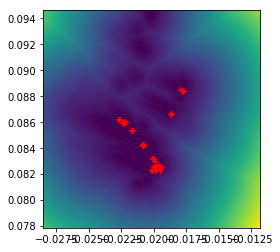

In [205]:
plt.imshow(outer_dist[f_ind], extent=(C13_data[0].x[0].item(),
                                C13_data[0].x[-1].item(),
                                C13_data[0].y[-1].item(),
                                C13_data[0].y[0].item()))
# plt.colorbar()
wh = np.all([flash_x[f_ind]>=C13_data[0].x[0].item(),
             flash_x[f_ind]<=C13_data[0].x[-1].item(),
             flash_y[f_ind]>=C13_data[0].y[-1].item(),
             flash_y[f_ind]<=C13_data[0].y[0].item()],
            axis=0)
plt.scatter(flash_x[f_ind][wh], flash_y[f_ind][wh], c='r', marker='+')


In [206]:
dist_test = interpolate.interpn((C13_data[0].y[::-1], C13_data[0].x),
                                outer_dist[f_ind][::-1],
                                np.stack([flash_y[f_ind], flash_x[f_ind]], axis=-1),
                                method='linear',
                                bounds_error=False,
                                fill_value=np.nan)

In [207]:
outer_dists = []
for i in range(outer_dist.shape[0]):
    outer_dists.append(interpolate.interpn((C13_data[0].y[::-1], C13_data[0].x),
                                outer_dist[i][::-1],
                                np.stack([flash_y[i], flash_x[i]], axis=-1),
                                method='linear',
                                bounds_error=False,
                                fill_value=np.nan))
outer_dists = np.concatenate(outer_dists)
outer_dists = ma.array(outer_dists, mask=np.isnan(outer_dists))

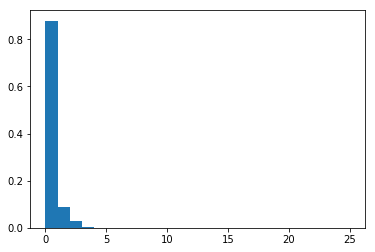

In [208]:
h = plt.hist(outer_dists, bins=np.arange(0,26), density=True,stacked=True)

In [127]:
plt.hist?

In [213]:
ndi.generate_binary_structure(3,2)

array([[[False,  True, False],
        [ True,  True,  True],
        [False,  True, False]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[False,  True, False],
        [ True,  True,  True],
        [False,  True, False]]])

In [223]:
isinstance(ma.array([0]), ma.core.MaskedArray)

True

In [222]:
type(ma.array([0]))

numpy.ma.core.MaskedArray

In [224]:
hasattr(ma.array([0]), 'data')

True

In [232]:
np.logical_not(np.logical_or(markers, mask))

masked_array(
  data=[[[True, True, True, ..., True, True, True],
         [True, True, True, ..., True, True, True],
         [True, True, True, ..., True, True, True],
         ...,
         [True, True, True, ..., True, True, True],
         [True, True, True, ..., True, True, True],
         [True, True, True, ..., True, True, True]],

        [[True, True, True, ..., True, True, True],
         [True, True, True, ..., True, True, True],
         [True, True, True, ..., True, True, True],
         ...,
         [True, True, True, ..., True, True, True],
         [True, True, True, ..., True, True, True],
         [True, True, True, ..., True, True, True]],

        [[True, True, True, ..., True, True, True],
         [True, True, True, ..., True, True, True],
         [True, True, True, ..., True, True, True],
         ...,
         [True, True, True, ..., True, True, True],
         [True, True, True, ..., True, True, True],
         [True, True, True, ..., True, True, True]],

  